### 1. 라이브러리

In [1]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from prophet import Prophet
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

Prophet 모델은 시계열 예측을 위해 설계된 모델로, 다른 시계열 모델과는 다르게 독립변수와 종속변수를 분리하여 학습시키는 방식이 아닌, 전체 데이터 프레임을 입력으로 받아 모델을 학습시킵니다. Prophet은 날짜 (ds)와 목표 변수 (y)를 가진 데이터 프레임을 입력으로 받습니다. 

### 2. 데이터 불러오기

In [3]:
file_path = 'tb_stock.xlsx'
df = pd.read_excel(file_path)

### 3. 데이터 전처리

In [5]:
# Prophet 모델은 date (ds), 목표값 (y) 데이터로 전처리 필요
df_prophet = df[['sc_date', 'sc_ap_stock']].rename(columns={'sc_date': 'ds', 'sc_ap_stock': 'y'})

# 데이터 프레임에 맞게 날짜/시간 조정
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

### 4. Prophet 학습

In [7]:
# Prophet 모델 초기화 및 학습
model = Prophet()
model.fit(df_prophet)

# 미래 데이터 예측
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

12:20:54 - cmdstanpy - INFO - Chain [1] start processing
12:20:55 - cmdstanpy - INFO - Chain [1] done processing


### 5. 평가지표

In [9]:
# 예측 결과와 실제 값을 병합
merged_df = pd.merge(df_prophet, forecast[['ds', 'yhat']], on='ds')
# 예측 결과(forecast)에서 날짜(ds)와 예측 값(yhat)을 추출하여 원래 데이터프레임(df_prophet)과 날짜(ds)를 기준으로 병합

# 평가 지표 계산
mse = mean_squared_error(merged_df['y'], merged_df['yhat'])   # MSE (Mean Squared Error) 계산
rmse = np.sqrt(mse)                                           # RMSE (Root Mean Squared Error) 계산
mae = mean_absolute_error(merged_df['y'], merged_df['yhat'])  # MAE (Mean Absolute Error) 계산
r2 = r2_score(merged_df['y'], merged_df['yhat'])              # R² (결정 계수) 계산

# 평가 지표 출력
print(f'MSE: {mse}')  # MSE 출력
print(f'RMSE: {rmse}')  # RMSE 출력
print(f'MAE: {mae}')  # MAE 출력
print(f'R²: {r2}')  # R² 출력

MSE: 49.40480986069066
RMSE: 7.028855515707423
MAE: 5.114902335155234
R²: 0.9865568964300142


### 6. 비교 차트

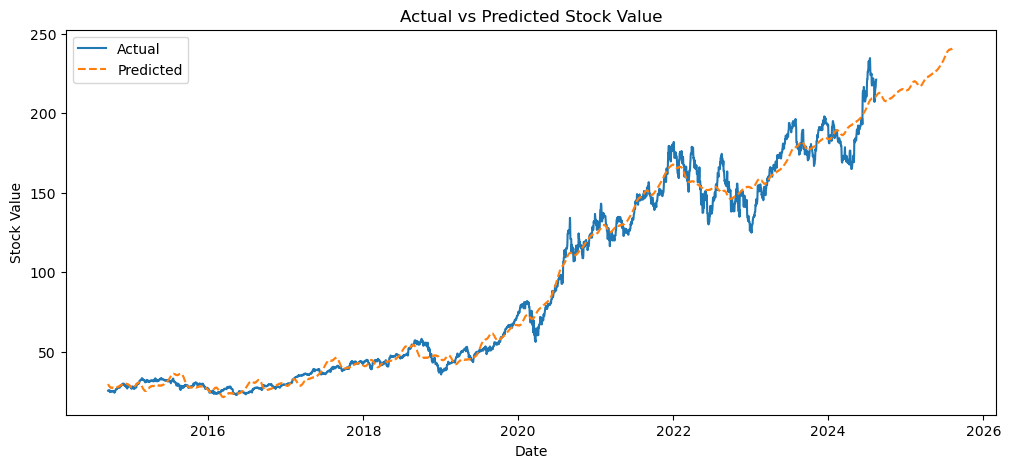

C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Users\4호실-2\AppData\Local\Temp\ipykernel_8660\436519335.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is

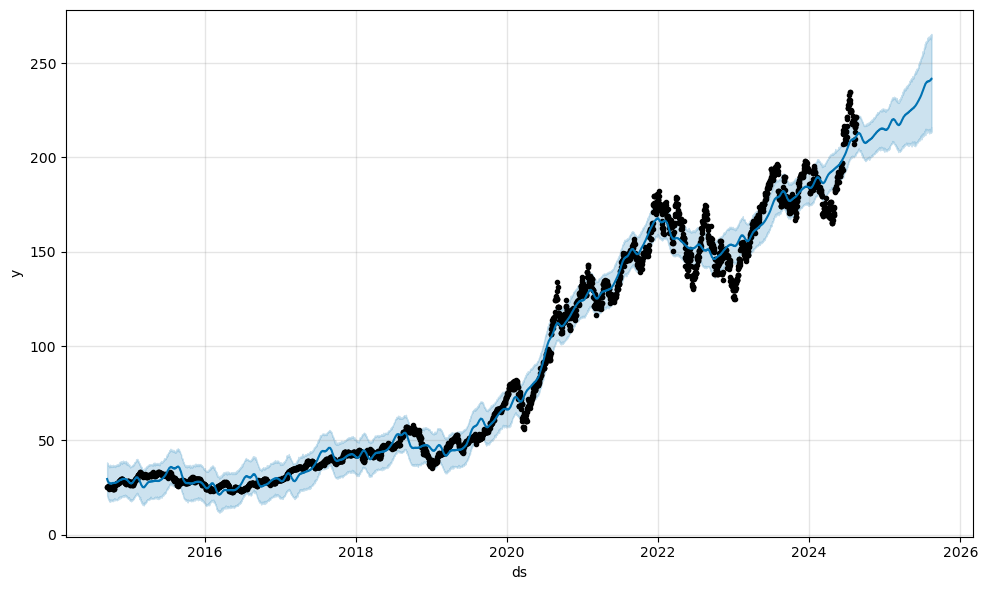

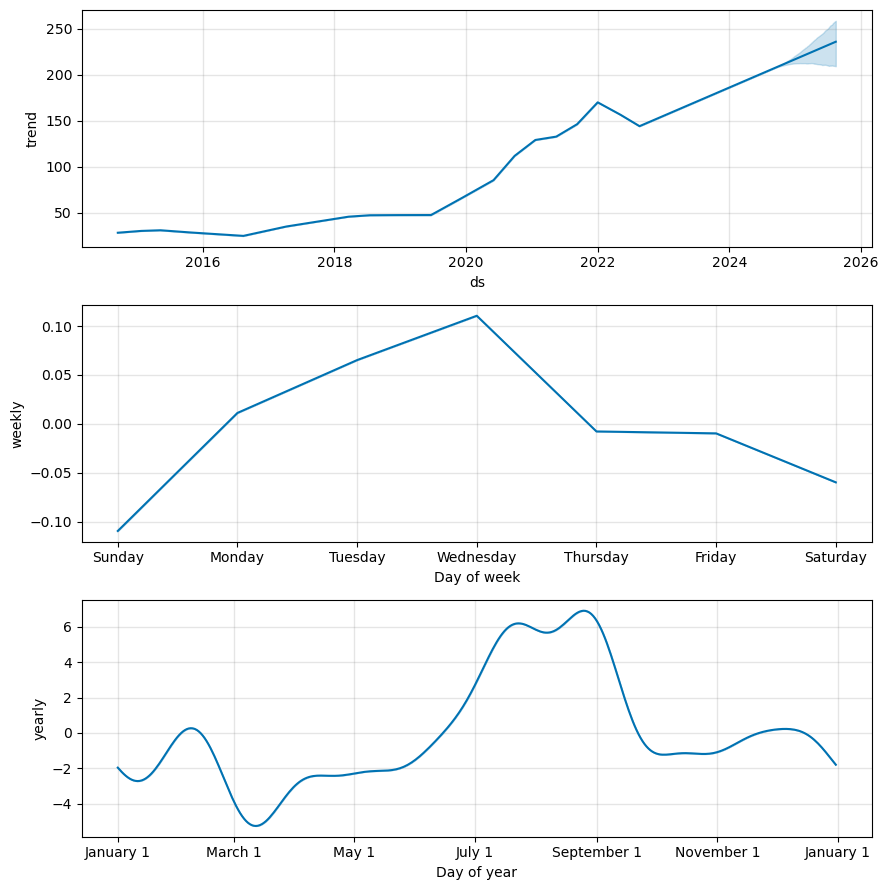

In [13]:
# 실제 데이터값과 예측 데이터값 비교 그래프
plt.figure(figsize=(12, 5))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', linestyle='--')
# plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('Stock Value')
plt.title('Actual vs Predicted Stock Value')
plt.legend()
plt.show()

# 예측 결과 시각화
fig = model.plot(forecast)
fig.show()

# 컴포넌트 분석 시각화
fig2 = model.plot_components(forecast)
fig2.show()

### 7. 그리드 서치

In [ ]:
# GidSearch를 활용한 하이퍼파라미터 조정

# 하이퍼파라미터 그리드 설정
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1.0],  # 트렌드 변화를 제어하는 하이퍼파라미터
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],         # 계절성 변화를 제어하는 하이퍼파라미터
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],            # 공휴일 효과를 제어하는 하이퍼파라미터
    'seasonality_mode': ['additive', 'multiplicative'],        # 계절성 모드 (additive 또는 multiplicative)
    'yearly_seasonality': [True, False],                       # 연간 계절성 포함 여부
    'weekly_seasonality': [True, False],                       # 주간 계절성 포함 여부
    'daily_seasonality': [True, False],                        # 일일 계절성 포함 여부
    'n_changepoints': [10, 25, 50, 100]                        # 트렌드 변화점의 수
}

# 모든 하이퍼파라미터 조합 생성
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
# itertools.product를 사용하여 모든 하이퍼파라미터 조합을 생성하고, 이를 딕셔너리 형태로 저장

# 최적의 파라미터를 저장할 변수
best_params = None  # 최적의 파라미터를 저장할 변수를 초기화
best_rmse = float('inf')  # 최적의 RMSE 값을 저장할 변수를 초기화 (처음엔 무한대로 설정)

# Grid Search
for params in tqdm(all_params):  # 모든 하이퍼파라미터 조합에 대해 반복
    # 모델 생성 및 학습
    model = Prophet(**params)  # 현재 하이퍼파라미터 조합으로 Prophet 모델 생성
    model.fit(data)  # 모델을 데이터로 학습
    
    # 예측
    forecast = model.predict(data)  # 학습한 모델로 예측 수행
    
    # RMSE 계산
    y_true = data['y'].values  # 실제 값
    y_pred = forecast['yhat'].values  # 예측 값
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # RMSE 계산
    
    # 최적의 파라미터 갱신
    if rmse < best_rmse:  # 현재 조합의 RMSE가 이전 최적 RMSE보다 낮으면
        best_rmse = rmse  # 최적의 RMSE 값을 업데이트
        best_params = params  # 최적의 하이퍼파라미터 조합을 저장

# 최적의 하이퍼파라미터와 RMSE 출력
print(f'Best Params: {best_params}')  # 최적의 하이퍼파라미터 출력
print(f'Best RMSE: {best_rmse}')  # 최적의 RMSE 값 출력


best_params = {'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'n_changepoints': 100}, 
Best RMSE: 4.401734940704953

#### 7-1. 그리드 서치 파라미터

In [15]:
best_params = {'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'n_changepoints': 100}
# Best RMSE: 4.401734940704953

#### 7-2. 학습

In [17]:
# 최적의 파라미터로 모델 학습
model = Prophet(**best_params)
model.fit(df_prophet)

# 미래 데이터 예측
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)  

12:21:15 - cmdstanpy - INFO - Chain [1] start processing
12:21:31 - cmdstanpy - INFO - Chain [1] done processing


#### 7-3. 평가지표

In [19]:
# 실제 값과 예측 값을 비교하여 성능 지표 계산
y_true = df_prophet['y'].values  # 실제 값
y_pred = forecast['yhat'][:len(df_prophet)].values  # 예측 값

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'Final RMSE: {rmse}')

# MSE (Mean Squared Error)
mse = mean_squared_error(y_true, y_pred)
print(f'Final MSE: {mse}')

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_true, y_pred)
print(f'Final MAE: {mae}')

# R^2 (결정 계수)
r2 = r2_score(y_true, y_pred)
print(f'Final R^2: {r2}')  

Final RMSE: 4.401734940704953
Final MSE: 19.37527048822284
Final MAE: 2.6334085174015
Final R^2: 0.9947279674063292


#### 7-4. 비교 차트

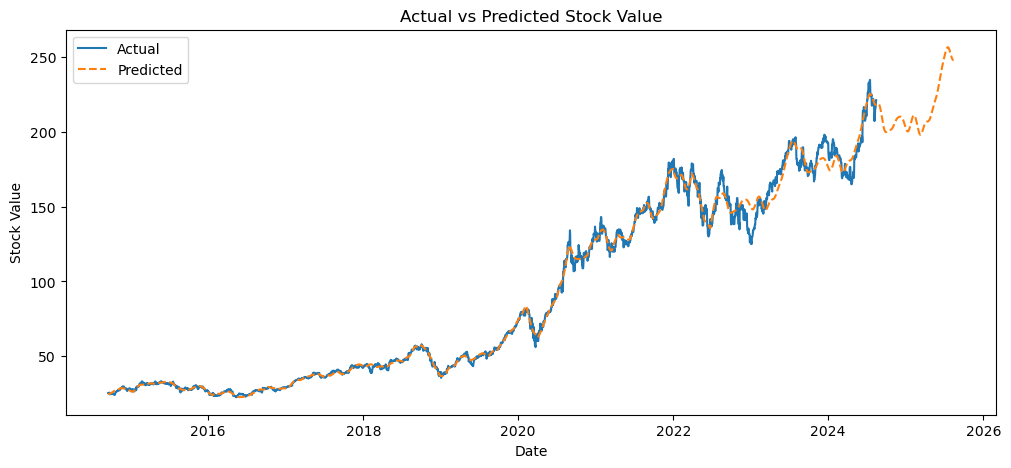

C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Users\4호실-2\AppData\Local\Temp\ipykernel_8660\1190041068.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime i

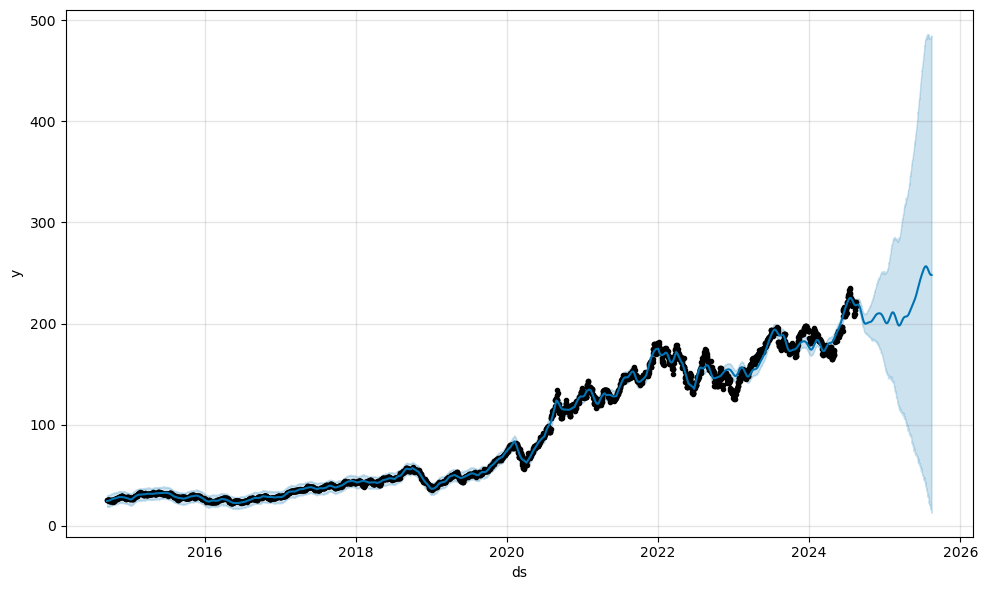

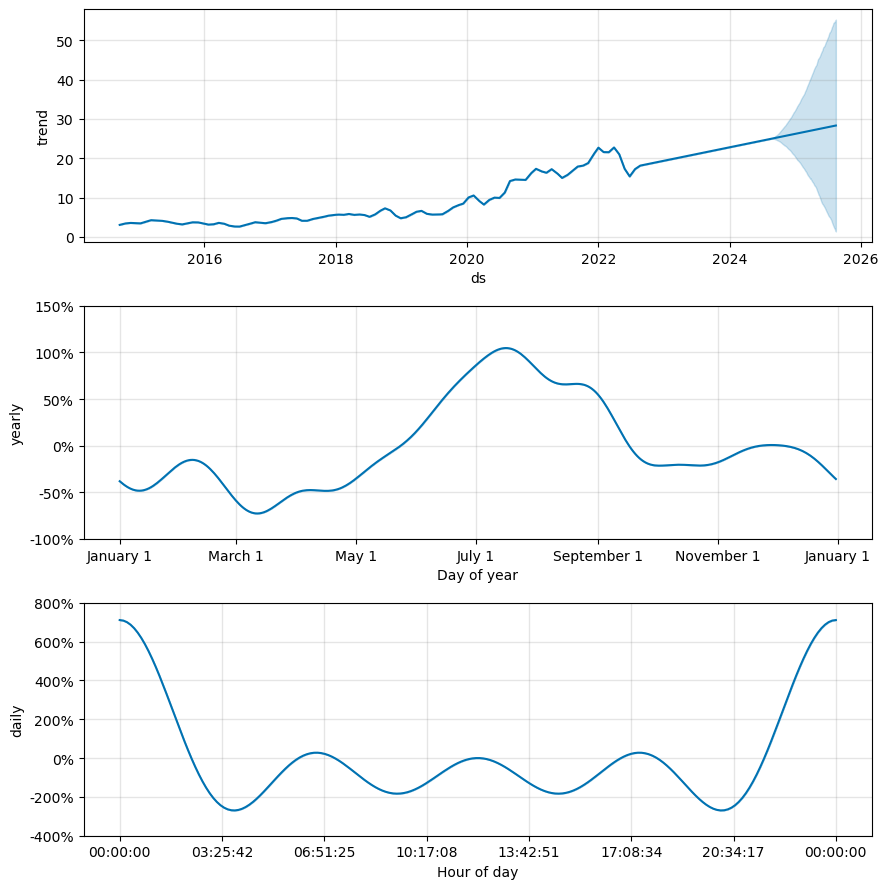

In [21]:
# 실제 데이터값과 예측 데이터값 비교 그래프
plt.figure(figsize=(12, 5))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Stock Value')
plt.title('Actual vs Predicted Stock Value')
plt.legend()
plt.show()

# 예측 결과 시각화
fig = model.plot(forecast)
fig.show()

# 컴포넌트 분석 시각화
fig2 = model.plot_components(forecast)
fig2.show()

In [23]:
# 실제 값과 예측 값을 비교하여 성능 지표 계산
y_true = df_prophet['y'].values  # 실제 값
y_pred = forecast['yhat'][:len(df_prophet)].values  # 예측 값

# 평가 지표 계산
mse = mean_squared_error(y_true, y_pred)  # 평균 제곱 오차 (MSE)
r2 = r2_score(y_true, y_pred)  # 결정 계수 (R^2)
mae = mean_absolute_error(y_true, y_pred)  # 평균 절대 오차 (MAE)
rmse = mean_squared_error(y_true, y_pred, squared=False)  # 루트 평균 제곱 오차 (RMSE)

print(f"테스트 데이터 평가:")
print(f"오차 제곱 평균 (MSE): {mse}")
print(f"데이터 변동성 (R^2): {r2}")
print(f"절대적 오차 (MAE): {mae}")
print(f"평균의 제곱근을 취한 값 (RMSE): {rmse}")

# 학습 데이터셋에 대한 평가 지표 계산
y_train_true = df_prophet['y'].values  # 학습 데이터의 실제 값
y_train_pred = forecast['yhat'][:len(df_prophet)].values  # 학습 데이터에 대한 예측 값

train_mse = mean_squared_error(y_train_true, y_train_pred)
train_r2 = r2_score(y_train_true, y_train_pred)

print(f"\n학습 데이터 평가:")
print(f"학습 데이터셋에 대한 모델의 성능을 평가 (MSE): {train_mse}")
print(f"학습 데이터셋에 대한 모델의 성능을 평가 R^2 점수: {train_r2}")

# 과적합 또는 과소적합 여부 확인
print("\n모델 평가:")
if train_r2 >= 0.8 and r2 < 0.8:
    print("과적합 가능성: 모델이 학습 데이터에 비해 테스트 데이터에서 성능이 낮음. 모델이 학습 데이터에 너무 적합되었을 수 있음.")
elif train_r2 < 0.8 and r2 < 0.8:
    print("과소적합 가능성: 모델이 학습 데이터와 테스트 데이터 모두에서 성능이 낮음. 모델이 데이터를 충분히 학습하지 못했을 수 있음.")
elif train_r2 >= 0.8 and r2 >= 0.8:
    print("모델이 잘 일반화되었습니다: 학습 데이터와 테스트 데이터 모두에서 높은 성능을 보임.")
else:
    print("예외적인 상황: 학습 데이터의 성능이 낮으나, 테스트 데이터의 성능이 높은 경우입니다. 일반적으로는 드문 상황입니다.")


테스트 데이터 평가:
오차 제곱 평균 (MSE): 19.37527048822284
데이터 변동성 (R^2): 0.9947279674063292
절대적 오차 (MAE): 2.6334085174015
평균의 제곱근을 취한 값 (RMSE): 4.401734940704953

학습 데이터 평가:
학습 데이터셋에 대한 모델의 성능을 평가 (MSE): 19.37527048822284
학습 데이터셋에 대한 모델의 성능을 평가 R^2 점수: 0.9947279674063292

모델 평가:
모델이 잘 일반화되었습니다: 학습 데이터와 테스트 데이터 모두에서 높은 성능을 보임.


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### 8. 모델 저장

In [25]:
# 모델 파일로 저장
with open('Regression_Apple_Prophet_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved as 'Regression_Apple_Prophet_model.pkl'")

Model saved as 'Regression_Apple_Prophet_model.pkl'


### 9. 모델 불러와서 사용

Model loaded from 'Regression_Apple_Prophet_model.pkl'


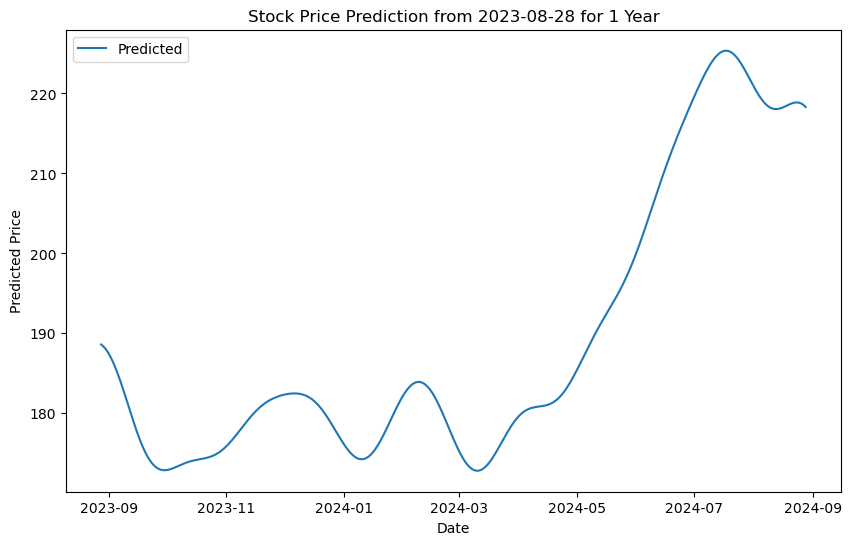

            ds        yhat  yhat_lower  yhat_upper
362 2024-08-24  218.868516  213.056994  225.278951
363 2024-08-25  218.814452  213.239574  224.866817
364 2024-08-26  218.706022  212.630810  224.391036
365 2024-08-27  218.537839  212.816665  224.697863
366 2024-08-28  218.305616  212.728029  224.620818


In [28]:
import pickle
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 저장된 모델 파일 불러오기
model_path = 'Regression_Apple_Prophet_model.pkl'
with open(model_path, 'rb') as f:
    model = pickle.load(f)

print("Model loaded from 'Regression_Apple_Prophet_model.pkl'")

def predict_next_year_from_date(start_date, model=model):
    """
    주어진 시작 날짜로부터 1년간의 주가 데이터를 예측하는 함수.
    
    :param model: 학습된 Prophet 모델
    :param start_date: 예측을 시작할 날짜 (YYYY-MM-DD 형식의 문자열)
    :return: 예측 결과 (DataFrame)
    """
    # 시작 날짜로부터 1년 후 날짜 계산
    future_dates = pd.date_range(start=start_date, periods=367, freq='D')
    future = pd.DataFrame({'ds': future_dates})
    
    # 예측 수행
    forecast = model.predict(future)

    # 예측된 주가 데이터 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(forecast['ds'], forecast['yhat'], label='Predicted')
    #plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
    plt.title(f'Stock Price Prediction from {start_date} for 1 Year')
    plt.xlabel('Date')
    plt.ylabel('Predicted Price')
    plt.legend()
    plt.show()

    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# 예시: 특정 날짜로부터 1년간의 예측
start_date = '2023-08-28'  # 예측을 시작할 날짜를 지정
print(predict_next_year_from_date(start_date))